# Objective

The objective of this notebook is to analyze and reduce the dimension of the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
y = np.load('target.npy')
x_size = np.load('f_size.npy')
x_asm = np.load('f_asm.npy')
x_unigram_bytes = np.load('f_unigram_bytes.npy')
x_bigram_bytes = np.load('f_bigram_bytes.npy')
x_pixel = np.load('f_pixel.npy')

### Correlation heatmaps

Correlation of asm features


/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


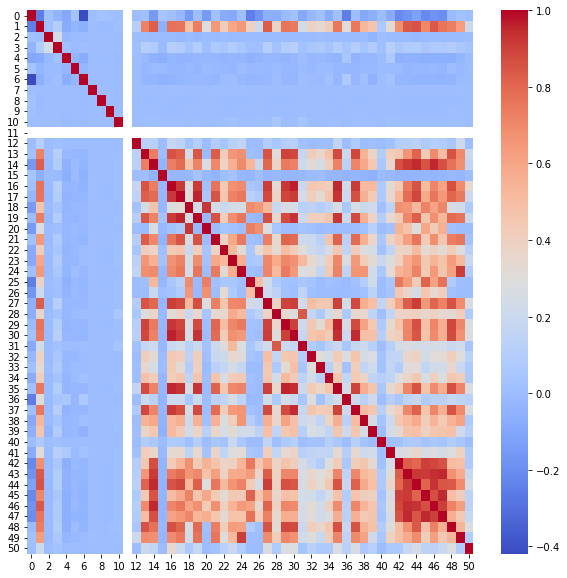

In [3]:
plt.figure(figsize = (10,10))
print("Correlation of asm features")
sns.heatmap(np.corrcoef(x_asm.T),cmap='coolwarm')
plt.show()

Correlation of pixel features


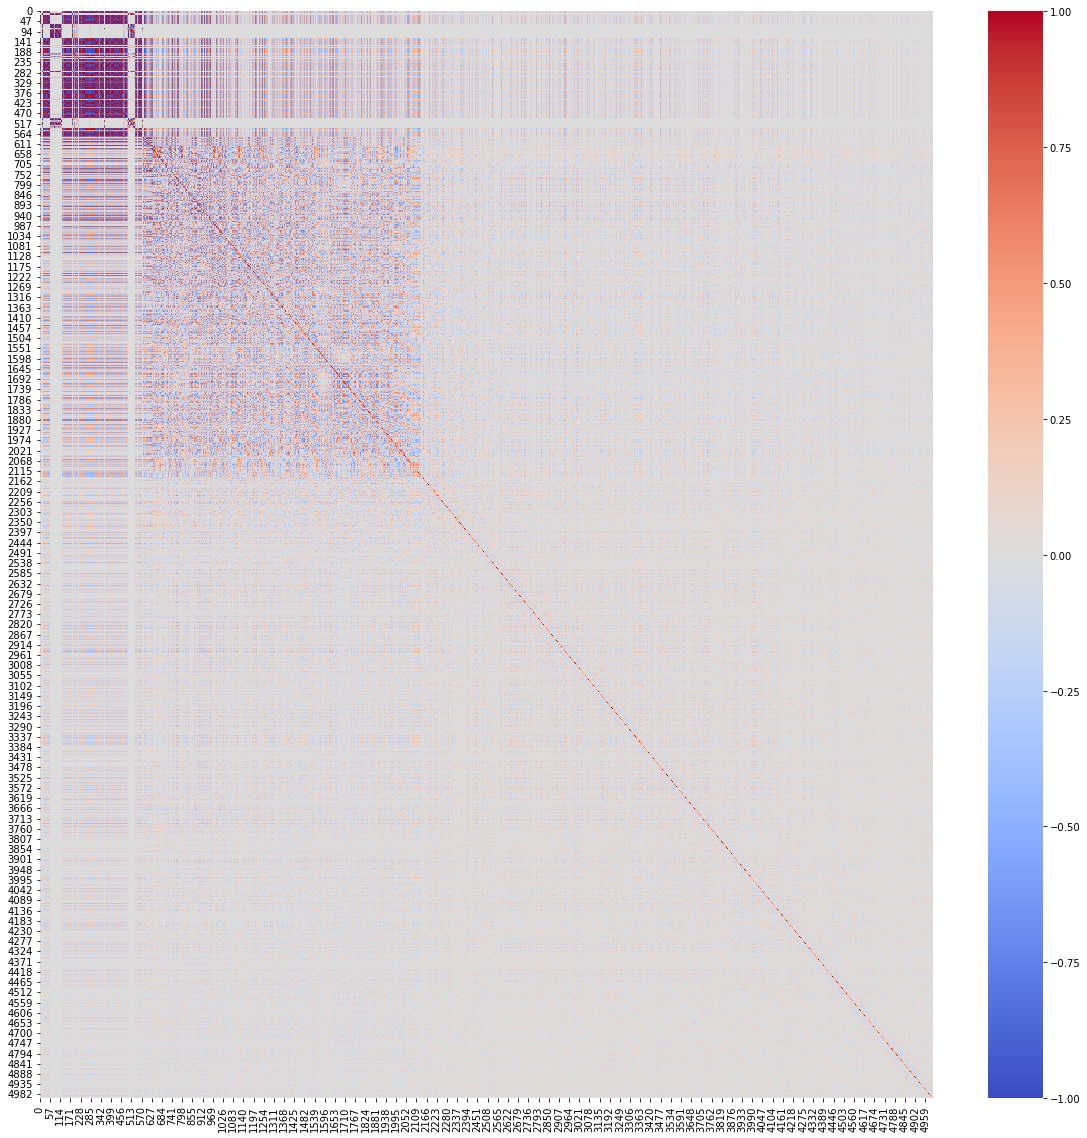

In [4]:
plt.figure(figsize = (20,20))
print("Correlation of pixel features")
sns.heatmap(np.corrcoef(x_pixel[:,:5000].T),cmap='coolwarm')
plt.show()

Correlation of size features
[[1.        0.3133472]
 [0.3133472 1.       ]]


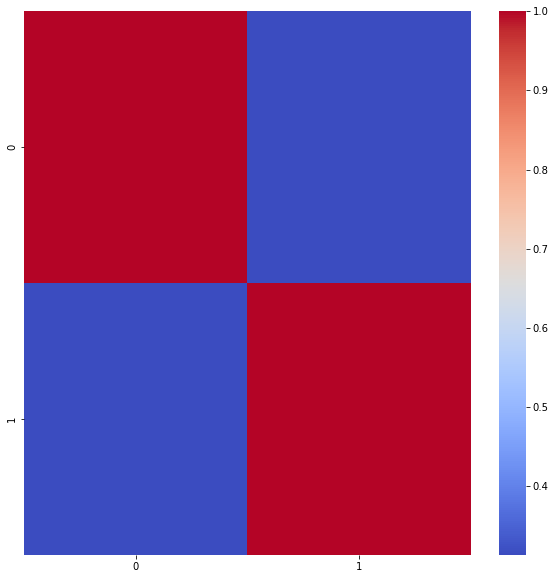

In [5]:
plt.figure(figsize = (10,10))
print("Correlation of size features")
sns.heatmap(np.corrcoef(x_size.T),cmap='coolwarm')
print(np.corrcoef(x_size.T))
plt.show()

Correlation of unigram_bytes features


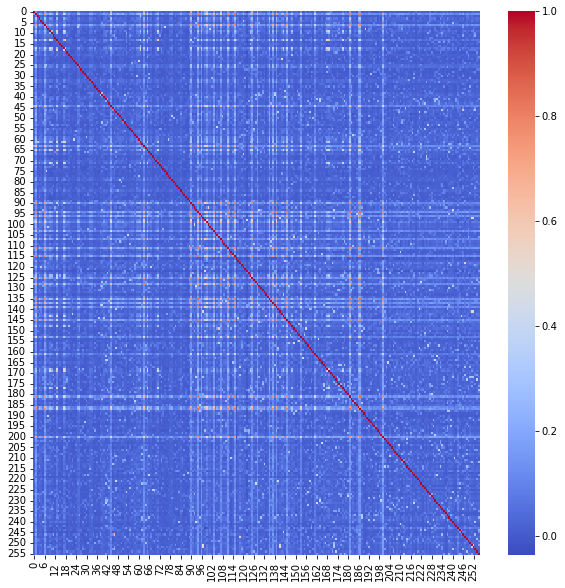

In [6]:
plt.figure(figsize = (10,10))
print("Correlation of unigram_bytes features")
sns.heatmap(np.corrcoef(x_unigram_bytes.T),cmap='coolwarm')
plt.show()

In [7]:
imp_features = np.hstack((x_size,x_asm, x_unigram_bytes,x_pixel[:,:2000]))

Correlation of important features


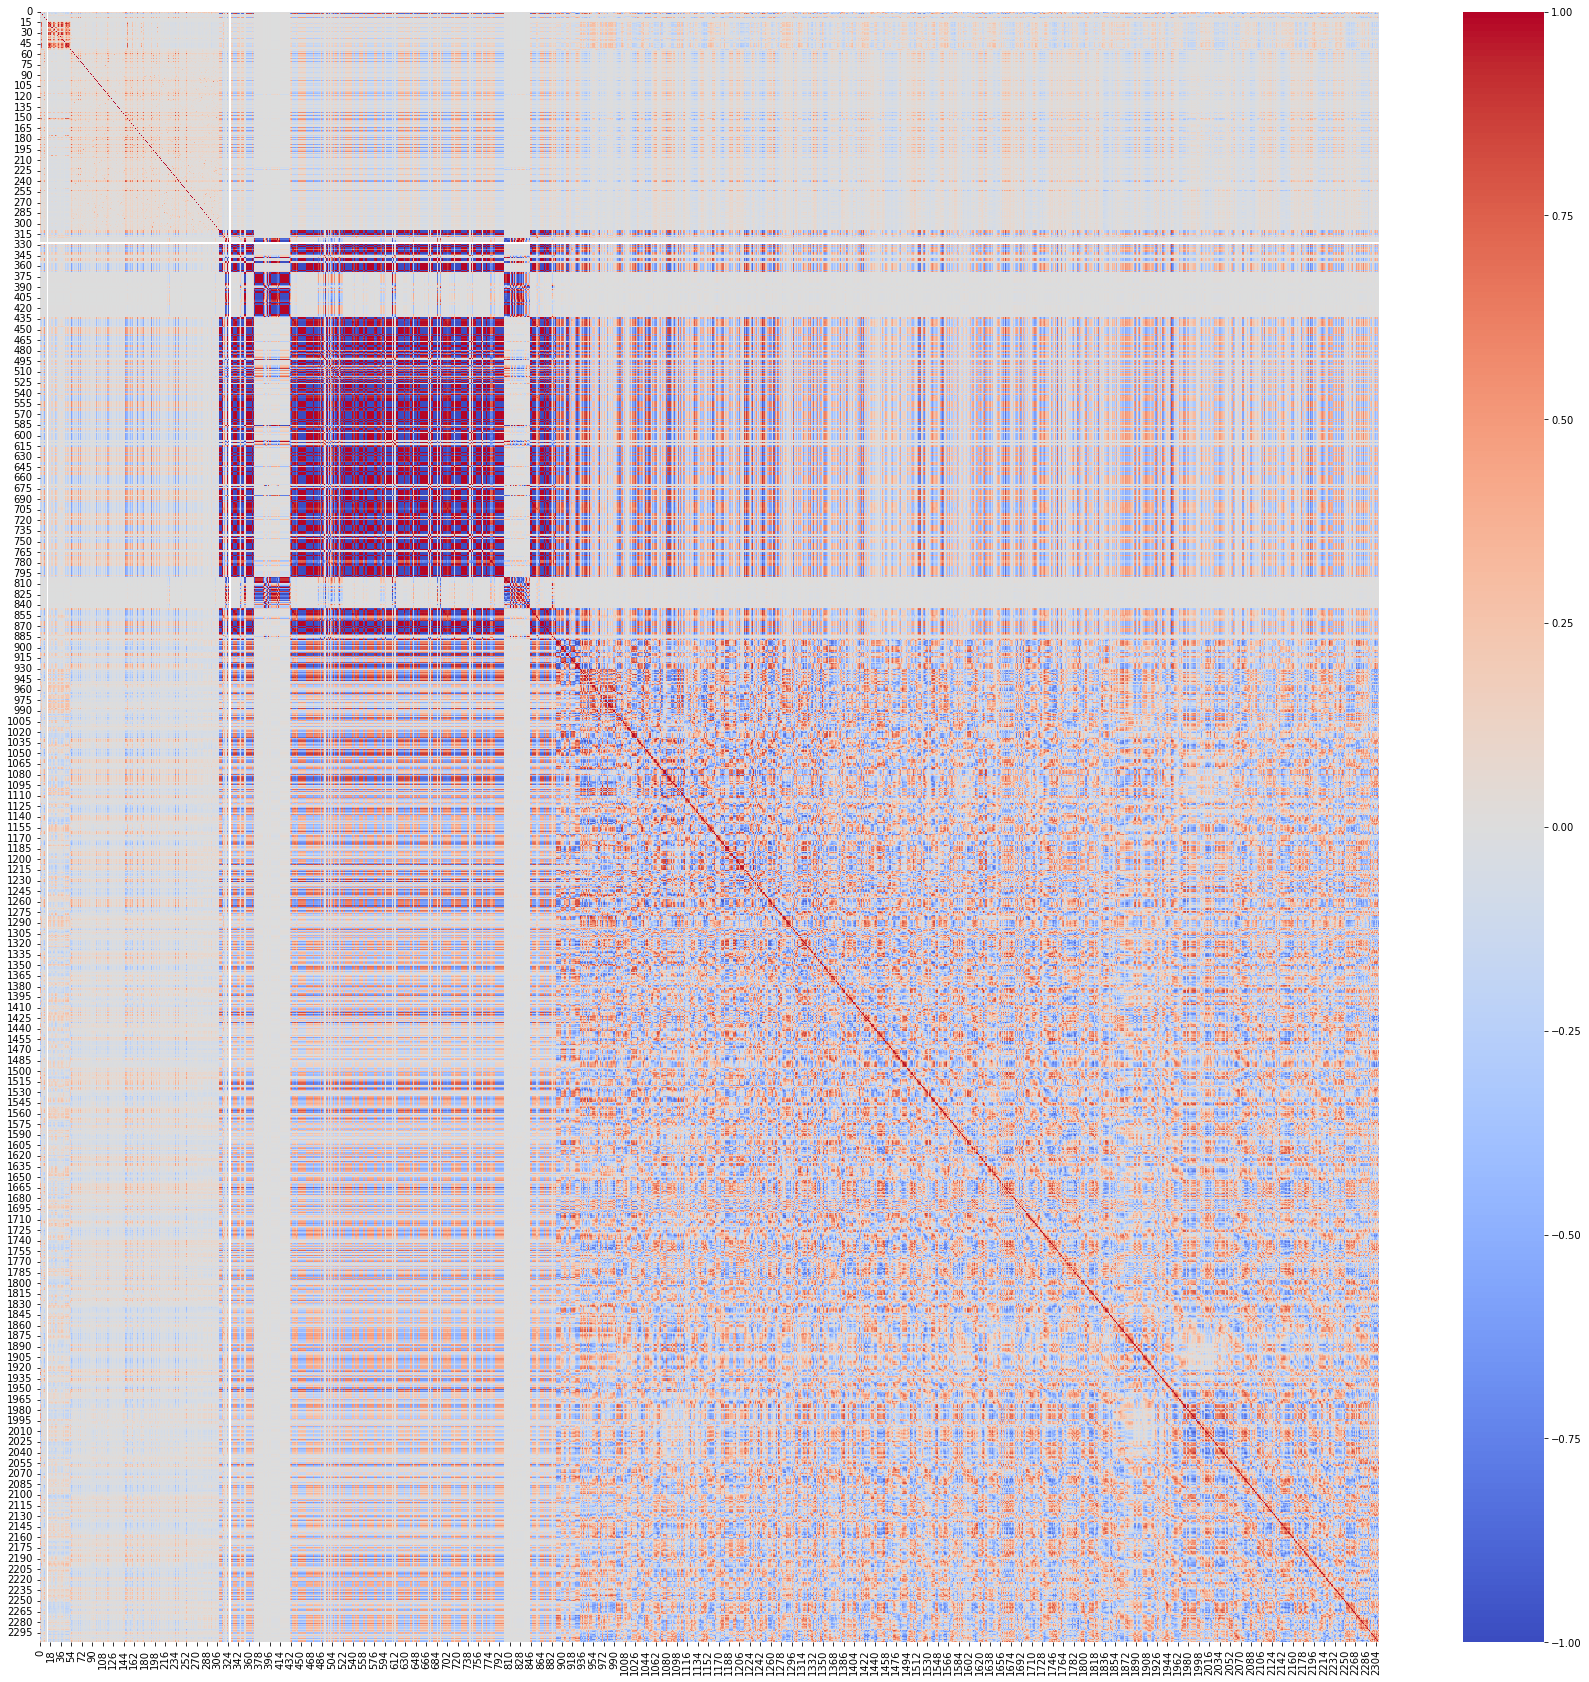

In [8]:
plt.figure(figsize = (30,30))
print("Correlation of important features")
sns.heatmap(np.corrcoef(imp_features.T),cmap='coolwarm')
plt.show()

### Class imbalances

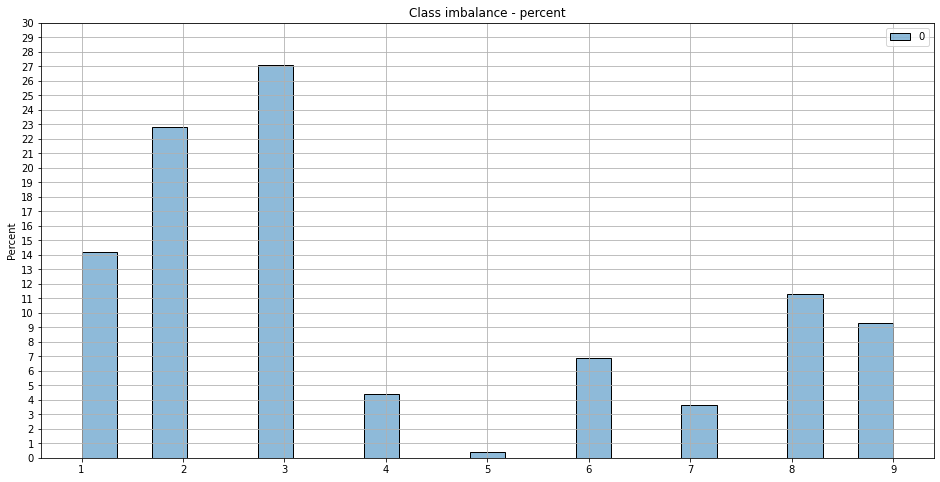

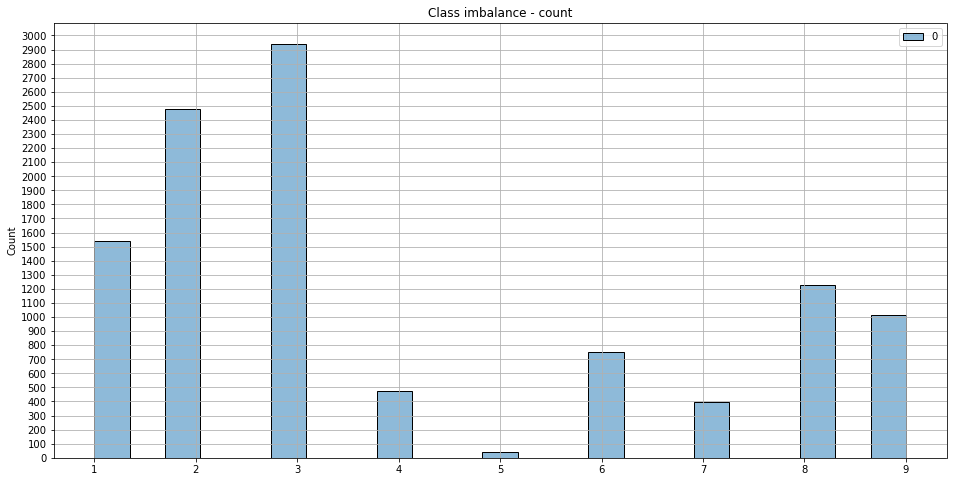

In [9]:
plt.figure(figsize=(16,8))
sns.histplot(y,stat='percent')
plt.title("Class imbalance - percent")
plt.yticks(range(0,31))
plt.grid()
plt.show()

plt.figure(figsize=(16,8))
sns.histplot(y,stat='count')
plt.title("Class imbalance - count")
plt.yticks(range(0,3001,100))
plt.grid()
plt.show()

## Box plot

In [10]:
x_asm.shape, y.shape

((10868, 51), (10868, 1))

bytes_size


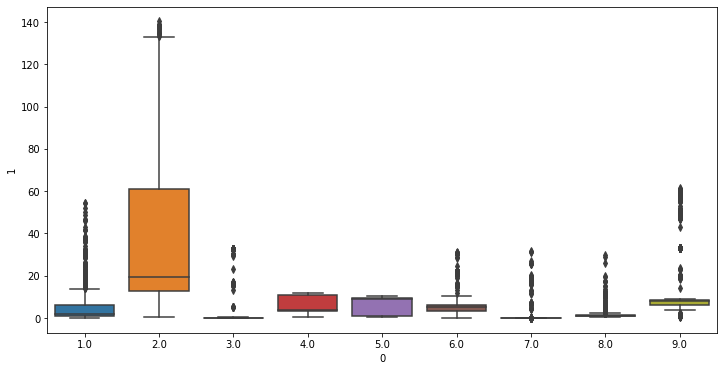

asm_size


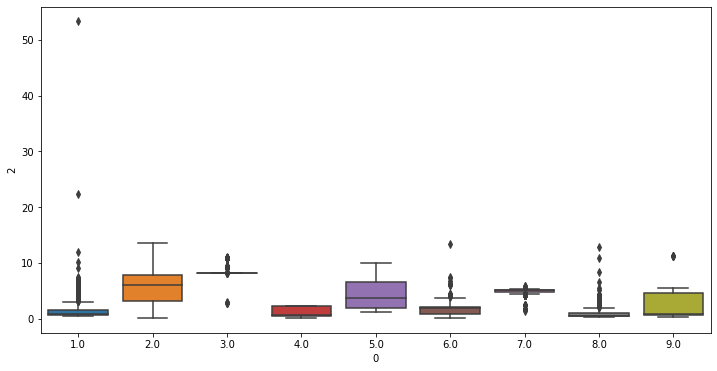

In [11]:

def box_plot(x,y,y_):
    plt.figure(figsize=(12,6))
    a = pd.DataFrame(np.hstack((y,x)))
    sns.boxplot(x=0,y=y_,data=a)
    plt.show()
    
print('bytes_size')
box_plot(x_size, y, 1) #bytes
print('asm_size')
box_plot(x_size, y, 2) #asm

# Feature Selection

# Set 1 Features
#### Unigram_byte_features + 2K_bigram_byte_features + ASM_features + 800_pixel_features then apply the XGBoost model.

In [13]:
x_bigram_bytes_reduced = SelectKBest(chi2, k=2500).fit_transform(x_bigram_bytes, y)
x_pixel_reduced = SelectKBest(chi2, k=1000).fit_transform(x_pixel, y)
x_set1 = np.hstack((x_unigram_bytes,x_bigram_bytes_reduced,x_asm,x_pixel_reduced))
print(x_set1.shape)
np.save('feature_set1.npy',x_set1)

(10868, 3807)


# Set 2  Features

#### Non zero features from xgbclassifier.feature_importances_ on train data. random_state=11

In [14]:
from sklearn.model_selection import train_test_split
y = np.load('target.npy')
x_size = np.load('f_size.npy')
x_asm = np.load('f_asm.npy')
x_unigram_bytes = np.load('f_unigram_bytes.npy')
x_bigram_bytes = np.load('f_bigram_bytes.npy')
x_pixel = np.load('f_pixel.npy')
x_all = np.hstack((x_size, x_asm, x_unigram_bytes, x_bigram_bytes, x_pixel))
print(x_all.shape)
x_train, x_test, y_train, y_test = train_test_split(x_all,y,test_size=0.2, random_state=11)
x_train, x_cv, y_train, y_cv = train_test_split(x_train,y_train,test_size=0.25, random_state=11)
print('Train:cv:test ::',y_train.shape[0],':',y_cv.shape[0],':',y_test.shape[0])

(10868, 76101)
Train:cv:test :: 6520 : 2174 : 2174


In [15]:
n_estimators = 500
clf = XGBClassifier(n_estimators = n_estimators, eval_metric='mlogloss')
clf.fit(x_train,y_train)
print('training rf complete.. starting calibration..')
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train.ravel())
print('logloss')
train_loss = log_loss(y_train,sig_clf.predict_proba(x_train))
loss = log_loss(y_cv,sig_clf.predict_proba(x_cv))
print(train_loss,loss)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training rf complete.. starting calibration..


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

logloss
0.011262188341650856 0.022154054211632464


In [16]:
feature_importance = clf.feature_importances_
important_features = pd.DataFrame({'feature_importance':feature_importance, 'Index':list(range(len(feature_importance)))})
important_features = important_features[important_features.feature_importance!=0]
x_important_xgb_k_features = x_all[:,important_features.Index.values]
np.save('featutre_set2_imp_features.npy', important_features.Index.values)

In [19]:
np.save('feature_set2.npy',x_all[:,important_features.Index.values])

# Summary

We got two features sets:
    
    - feature_set1.npy uses SelectKBest features on higly dimensinal bigram bytes and pixel intensity features.
    
    - feature_set2.npy uses features importance from a 500 estimator trained XGBoost Classifier model with train data having random state 11 as split.